In [2]:
from __future__ import print_function, division
import sys, os
from collections import OrderedDict

from RAFT.core.raft import RAFT
import tqdm

# sys.path.append('core')

import argparse
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from RAFT.core.datasets import MpiSintel, KubricDataset, KITTI
from RAFT.core.utils import flow_viz
from RAFT.core.utils.utils import InputPadder, InputCropAndResize
from RAFT.core.utils.flow_viz import flow_to_color
import einops

from RAFT.core.utils.statistics import CombinedStatistics
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import scipy
from skimage.metrics import structural_similarity as ssim

%load_ext autoreload
%autoreload 2

os.chdir('/mnt/datagrid/personal/neoral/repos/raft_new_debug/RAFT/')


def mkdir_if_not_exist(path):
    if not os.path.isdir(path):
        os.makedirs(path)

def mkdir_from_full_file_path_if_not_exist(path):
    basename = os.path.basename(path)
    mkdir_if_not_exist(path[:-len(basename)])

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__.update(kwargs)

/mnt/datagrid/personal/neoral/app/pytorch160python36cuda101/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
myhost = os.uname()[1]
print(myhost)

boruvka


In [4]:
default_kwargs = {
    'model': '/home.stud/neoramic/repos/raft_new_debug/RAFT/checkpoints/raft-things-sintel-kubric-splitted-occlusion-uncertainty-non-occluded-base-sintel.pth',
    'save_path': '/datagrid/personal/neoral/RAFT_occl_uncertainty_outputs/statistics_occl',
    'iters': 24,
    'gpus': 2,
    'debug': True,
    'subsplit': None
}
args = AttrDict(**default_kwargs)

In [5]:
device = f'cuda:{args.gpus}'

raft_kwargs = {
    'occlusion_module': 'separate_with_uncertainty',
    'restore_ckpt': args.model,
    'small': False,
    'mixed_precision': False,
}
raft_params = AttrDict(**raft_kwargs)

# Of course, you can use argparse instead of attr_dict
raft = torch.nn.DataParallel(RAFT(raft_params))
raft.load_state_dict(torch.load(args.model, map_location='cpu'))

raft = raft.module
raft.requires_grad_(False)
raft.to(device)
raft.eval()

# DATASET WITH GT FLOW and OCCL
# kubric_validation = KubricDataset(split='validation', load_occlusion=True, correct_flow=True)
kitti = KITTI(split='training')
sintel_clean = MpiSintel(split='training', dstype='clean', load_occlusion=True, subsplit=args.subsplit)
sintel_final = MpiSintel(split='training', dstype='final', load_occlusion=True, subsplit=args.subsplit)

subsplit_name = '' if args.subsplit is None else f'_{args.subsplit}'
datasets = {
            f'kitti': kitti,
            f'sintel_final{subsplit_name}': sintel_final,

            # 'kubric_val_corrected_flow': kubric_validation,
            f'sintel_clean{subsplit_name}': sintel_clean,
            }

200


In [45]:
class FlowEvaluator():
    def __init__(self, name, n_zones=0):
        self.name = name
        self.n_zones = n_zones
        self.epe_list = {k:[] for k in range(n_zones+1)}
        self.fl_array_list = {k:[] for k in range(n_zones + 1)}

    def __call__(self, *args, **kwargs):

        data = OrderedDict()
        for k in range(self.n_zones + 1):
            name_epe = 'EPE (all)' if k == 0 else f'EPE (zone {k})'
            data[name_epe] = np.array(self.epe_list[k]).mean()
        for k in range(self.n_zones + 1):
            name_fl = 'Fl (all)' if k == 0 else f'Fl (zone {k})'
            data[name_fl] = np.concatenate(self.fl_array_list[k]).mean() * 100.0
        return pd.DataFrame(data, index=[self.name])

    def evaluate_flow_single(self, flow_est, flow_gt, valid, zone_mask=None):
        epe = torch.sum((flow_est - flow_gt)**2, dim=0).sqrt()
        mag = torch.sum(flow_gt**2, dim=0).sqrt()
        epe = epe.view(-1)
        mag = mag.view(-1)
        if zone_mask is not None:
            valid = zone_mask * valid
        val = torch.reshape(valid, (-1,)) >= 0.5
        fl = ((epe > 3.0) & ((epe/mag) > 0.05)).float()
        epe_valid = epe[val].mean().item()
        fl_valid_array = fl[val].cpu().numpy()
        return epe_valid, fl_valid_array

    def create_zone_mask(self, valid_mask, current_n_zone, max_n_zone):
        # current_zone "0" covers whole image
        if current_n_zone == 0:
            return None, None
        data_shape = einops.parse_shape(valid_mask, 'N C H W')
        chunk_size_W = data_shape['W'] / (2 * max_n_zone)
        ration_H = data_shape['W'] / data_shape['H']

        X, Y = np.meshgrid(range(data_shape['W']), range(data_shape['H']))
        X_template = np.minimum(X,np.flip(X, axis=1))
        Y_template = np.minimum(Y,np.flip(Y,axis=0)) * ration_H
        dist = np.minimum(X_template, Y_template)

        zone_min = chunk_size_W * (current_n_zone - 1) if current_n_zone != 1 else -1
        zone_max = chunk_size_W * (current_n_zone)
        eval_zone_np = np.logical_and(dist > zone_min,  dist <= zone_max) * 1.0
        # plt.imshow(eval_zone)
        # plt.show()
        eval_zone = torch.from_numpy(einops.rearrange(eval_zone_np, 'H W -> 1 1 H W')).to(valid_mask.device)
        return eval_zone, eval_zone_np

    def plot_template_mask_sample(self, shape, max_n_zone=None):
        max_n_zone = self.n_zones if max_n_zone is None else max_n_zone
        empty_image = torch.ones(shape)
        print(empty_image.shape)
        masks = [self.create_zone_mask(empty_image, current_n_zone=i, max_n_zone=max_n_zone)[1] * i for i in range(1, max_n_zone + 1)]
        print(masks[0].shape)
        template_mask = np.sum(np.stack(masks, axis=0), axis=0)
        print(template_mask.shape)
        plt.figure(figsize=(10,15))
        plt.imshow(template_mask)
        H, W = template_mask.shape
        for i in range(1, max_n_zone + 1):
            plt.text((i - 0.5) * W/(2 * max_n_zone), H/2,  str(i), fontsize=22)
        plt.title('Area for evaluation')
        plt.tight_layout()
        plt.savefig('area.png')
        plt.show()

    def evaluate_flow(self, flow_est, flow_gt, valid):
        if flow_est.ndim == 4:
            flow_est = torch.squeeze(flow_est, 0)
        if flow_gt.ndim == 4:
            flow_gt = torch.squeeze(flow_gt, 0)

        for k in range(self.n_zones + 1):
            zone_mask = self.create_zone_mask(valid, k, self.n_zones)[0]
            epe_valid, f1_valid_array = self.evaluate_flow_single(flow_est, flow_gt, valid, zone_mask=zone_mask)
            self.epe_list[k].append(epe_valid)
            self.fl_array_list[k].append(f1_valid_array)



Processing dataset kitti:
torch.Size([1, 1, 480, 1024])
(480, 1024)
(480, 1024)


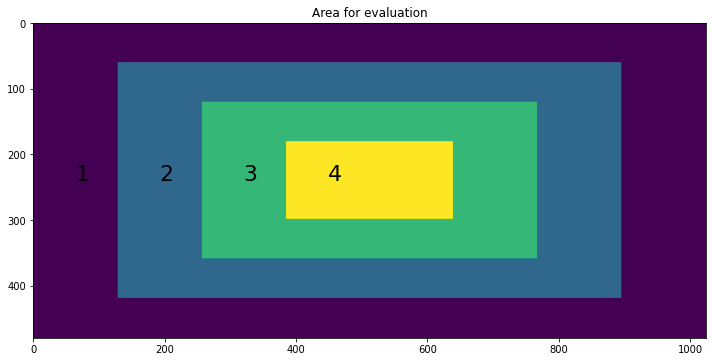

100%|██████████| 200/200 [03:50<00:00,  1.15s/it]


Processing dataset sintel_final:
torch.Size([1, 1, 480, 1024])
(480, 1024)
(480, 1024)


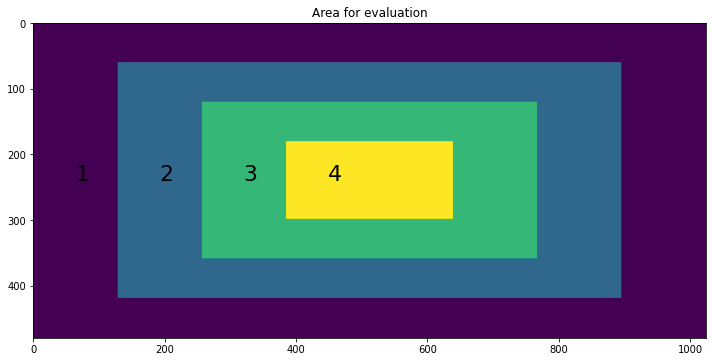

100%|██████████| 1041/1041 [19:27<00:00,  1.12s/it]


Processing dataset sintel_clean:
torch.Size([1, 1, 480, 1024])
(480, 1024)
(480, 1024)


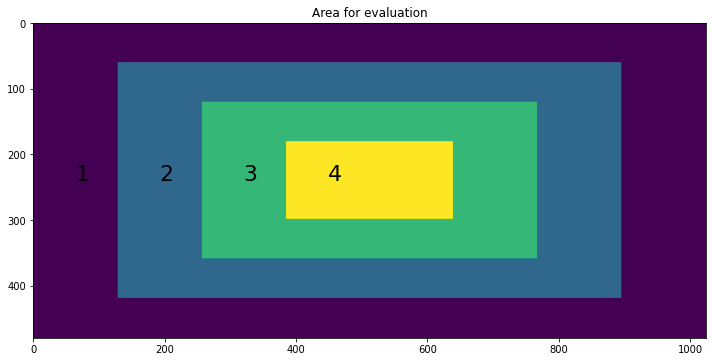

100%|██████████| 1041/1041 [17:31<00:00,  1.01s/it]


In [46]:
unvalidate_borders_px = 0
normalise_input = True

n_zones = 4
df_list = []

for dataset_name, data in datasets.items():
    print(f'Processing dataset {dataset_name}:')

    FE_full = FlowEvaluator(name='Full image (cropped for eval)', n_zones=n_zones)
    FE_full.plot_template_mask_sample([1, 1, 480, 1024])
    FE_crop = FlowEvaluator(name='Cropped image', n_zones=n_zones)
    FE_crop_up = FlowEvaluator(name='Upsize image', n_zones=n_zones)

    for idx in tqdm.trange(len(data)):

        # IM LOADING
        im1o, im2o, flow_gt, valid, occl_gt = data[idx]
        c_im1_path = data.get_reference_frame_path(idx, relative=True)

        im1o = torch.unsqueeze(im1o, 0)
        im2o = torch.unsqueeze(im2o, 0)
        flow_gto = torch.unsqueeze(flow_gt, 0)
        valid_gto = torch.unsqueeze(valid, 0)

        cropper = InputCropAndResize(scale=0.5)
        im1_crop, im2_crop, flow_gt_crop, valid_gt_crop = cropper.crop(im1o, im2o, flow_gto, valid_gto)

        if unvalidate_borders_px != 0:
            valid_gt_crop[:,:,:unvalidate_borders_px,:] = 0.
            valid_gt_crop[:,:,-unvalidate_borders_px:,:]= 0.
            valid_gt_crop[:,:,:,:unvalidate_borders_px]= 0.
            valid_gt_crop[:,:,:,-unvalidate_borders_px:]=0.


        # RAFT FULL (CROP AFTER, FOR COMPARISON)
        padder = InputPadder(im1o.shape, mode='sintel' if dataset_name != 'kitti' else 'kitti')
        im1_pad, im2_pad = padder.pad(im1o, im2o)
        # print('input: ', im1_crop_pad.shape)
        predictions_pad = raft(im1_pad.to(device), im2_pad.to(device), iters=args.iters, test_mode=True, normalise_input=normalise_input)
        flow_pred = padder.unpad(predictions_pad['flow'])
        flow_pred = torch.squeeze(cropper.crop(flow_pred)[0], dim=0).detach().cpu()


        # RAFT FOR CROP
        padder_crop = InputPadder(im1_crop.shape, mode='sintel' if dataset_name != 'kitti' else 'kitti')
        im1_crop_pad, im2_crop_pad = padder_crop.pad(im1_crop, im2_crop)
        # print('input: ', im1_crop_pad.shape)
        predictions_crop_pad = raft(im1_crop_pad.to(device), im2_crop_pad.to(device), iters=args.iters, test_mode=True, normalise_input=normalise_input)
        flow_crop_pred = torch.squeeze(padder_crop.unpad(predictions_crop_pad['flow']), dim=0).detach().cpu()


        # RAFT FOR CROP UPSCALE
        im1_crop_up, im2_crop_up = cropper.upsize(im1_crop, im2_crop)
        padder_crop_up = InputPadder(im1_crop_up.shape, mode='sintel' if dataset_name != 'kitti' else 'kitti')
        im1_crop_up_pad, im2_crop_up_pad = padder_crop_up.pad(im1_crop_up, im2_crop_up)
        # print('input: ', im1_crop_up_pad.shape)
        predictions_crop_up_pad = raft(im1_crop_up_pad.to(device), im2_crop_up_pad.to(device), iters=args.iters, test_mode=True, normalise_input=normalise_input)
        flow_crop_up_pred = padder_crop_up.unpad(predictions_crop_up_pad['flow'])
        flow_crop_up_pred = torch.squeeze(cropper.downsize_flow(flow_crop_up_pred)[0], dim=0).detach().cpu()


        # print(flow_crop_up_pred.shape)
        # print(flow_crop_pred.shape, flow_gt.shape)
        # print(flow_gto.shape, flow_gt_crop.shape)
        #
        # plt.figure(figsize=(15,8))
        # plt.imshow(flow_gt_crop.cpu().detach().numpy()[0][0])
        # plt.colorbar()
        # plt.show()
        #
        # plt.figure(figsize=(15,8))
        # plt.imshow(flow_pred.cpu().detach().numpy()[0])
        # plt.colorbar()
        # plt.show()
        #
        # plt.figure(figsize=(15,8))
        # plt.imshow(flow_crop_pred.cpu().detach().numpy()[0])
        # plt.colorbar()
        # plt.show()
        #
        # plt.figure(figsize=(15,8))
        # plt.imshow(flow_crop_up_pred.cpu().detach().numpy()[0])
        # plt.colorbar()
        # plt.show()

        FE_full.evaluate_flow(flow_pred, flow_gt_crop, valid_gt_crop)
        FE_crop.evaluate_flow(flow_crop_pred, flow_gt_crop, valid_gt_crop)
        FE_crop_up.evaluate_flow(flow_crop_up_pred, flow_gt_crop, valid_gt_crop)

        # if args.debug:
        #     if idx >= 0:
        #         break

    c_orig_df = FE_full()
    c_crop_df = FE_crop()
    c_upsize_df = FE_crop_up()
    df_list.append(pd.concat([pd.concat([c_orig_df, c_crop_df, c_upsize_df])], keys=[f'{dataset_name} ({im1_crop.shape[2]}x{im1_crop.shape[3]})']))


    # epe = np.mean(epe_list_crop_eval)
    # print(np.mean(epe))
    # if args.debug:
    #     break

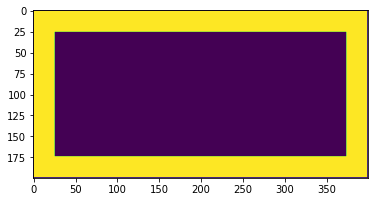

In [8]:
# test_map = np.zeros([200,400])
# X, Y = np.meshgrid(range(400), range(200))
# test_img_map = np.minimum(np.minimum(X,np.flip(X, axis=1)),np.minimum(Y,np.flip(Y,axis=0)))
# test_img_map = np.logical_and(test_img_map > 0,  test_img_map <= 25)
# plt.imshow(test_img_map)

In [49]:
df_all = pd.concat(df_list)
pd.set_option("display.precision", 2)

print(df_all.to_latex())

\begin{tabular}{llrrrrrrrrrr}
\toprule
                       &              &  EPE (all) &  EPE (zone 1) &  EPE (zone 2) &  EPE (zone 3) &  EPE (zone 4) &  Fl (all) &  Fl (zone 1) &  Fl (zone 2) &  Fl (zone 3) &  Fl (zone 4) \\
\midrule
kitti (188x620) & Full image (cropped for eval) &       0.73 &          0.89 &          0.69 &          0.51 &          0.47 &      2.75 &         3.76 &         2.79 &         1.43 &         0.57 \\
                       & Cropped image &       1.01 &          1.49 &          0.74 &          0.52 &          0.50 &      4.89 &         8.65 &         3.17 &         1.52 &         0.72 \\
                       & Upsize image &       0.92 &          1.39 &          0.65 &          0.46 &          0.48 &      4.09 &         7.30 &         2.43 &         1.46 &         0.61 \\
sintel\_final (218x512) & Full image (cropped for eval) &       1.14 &          1.12 &          1.22 &          1.09 &          1.01 &      5.30 &         4.93 &         5.65 &     

In [ ]:
plt.figure(figsize=(15,8))
plt.imshow(flow_gt_crop.cpu().detach().numpy()[0][0])
plt.colorbar()
plt.show()

plt.figure(figsize=(15,8))
plt.imshow(flow_pred.cpu().detach().numpy()[0])
plt.colorbar()
plt.show()

plt.figure(figsize=(15,8))
plt.imshow(flow_crop_pred.cpu().detach().numpy()[0])
plt.colorbar()
plt.show()

plt.figure(figsize=(15,8))
plt.imshow(flow_crop_up_pred.cpu().detach().numpy()[0])
plt.colorbar()
plt.show()


plt.figure(figsize=(15,8))
plt.imshow(valid_gt_crop.cpu().detach().numpy()[0][0])
plt.colorbar()
plt.show()



In [ ]:
flow_crop_up_pred.cpu().detach().numpy()[0].shape

In [ ]:
epe = np.mean(np.concatenate(epe_list))

In [ ]:
valid_gt_crop.shape